### What is this notebook for? ###

The main purpose of this notebook is buiding Liquidity's probability model for the Imovirtual, category "apartments for rent".

**Prerequisities:** "ml_dataset_imovirtual.tsv". Can be obtained with `2.QualityDriversDataPrepImovirtual-Jun-Dec.ipynb`

**Output:**

* Stored model: `xgb_imo_rent_02.pkl`
* Average price for city/rooms_num: `avg_city_price_imo_rent_02.csv`
* Model columns name: `model_columns_xgb_imo_rent_02.pkl`

In [1]:
import pandas as pd
import numpy as np

from sklearn.externals import joblib
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report

from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset_full = pd.read_csv("ml_dataset_imovirtual.tsv", sep ="\t")

Select only listings in category 102, apartments for sell.

In [4]:
dataset_full = dataset_full[dataset_full['category_id'] == 102]

We will train our model on Jun-Nov data:

In [5]:
train_full = dataset_full[dataset_full['month'] !=12]

Data validation on December data:

In [6]:
cv_full =  dataset_full[dataset_full['month'] ==12]

In [7]:
def create_liquid_field(dataframe):
    dataframe['unique_senders'] = dataframe['unique_senders'].fillna(0).astype('int')
    dataframe['liquid'] = (dataframe['unique_senders'] >= 3).astype('int')
    return dataframe

In [8]:
def select_category(dataframe, category_id):
    dataframe = dataframe[dataframe['category_id'] == category_id]
    return dataframe

In [9]:
def select_columns(dataframe, columns):
    dataframe = dataframe[columns]
    return dataframe

In [10]:
columns =  ['ad_id',
            'city_id', 
            'title', 
            'description', 
            'private_business',
            'n_images2',
            'was_paid_for_post', 
            'is_paid_for_post', 
            'street_name',
            'mysql_search_m', 
            'mysql_search_price',
            'rooms_num', 
            'bathrooms_num',
            'condition', 
            'construction_year',
            'energy_certificate', 
            'negotiable',
            'exchange',
            'unique_senders']

In [11]:
def filter_values(dataframe, col, values_list):
    dataframe = dataframe[dataframe[col].isin(values_list)]
    return dataframe

In [12]:
def remove_outliers(dataframe, col, lower_bound, upper_bound):
    dataframe = dataframe[(dataframe[col] >= lower_bound) & (dataframe[col] <= upper_bound)]
    return dataframe

In [13]:
def add_avg_price_city_ap_type(dataframe):
    city_n = pd.DataFrame({'city_n': dataframe.groupby(['city_id'])['ad_id'].nunique()}).reset_index()
    city_room_avg_price = pd.DataFrame({'avg_price': dataframe.groupby(['city_id', 'rooms_num'])['mysql_search_price'].mean()}).reset_index()
    dataframe = dataframe.merge(city_n, on='city_id', how='left')
    dataframe = dataframe.merge(city_room_avg_price, on = ['city_id', 'rooms_num'], how='left')
    #dataframe = dataframe[dataframe["city_n"] >= 30]
    return dataframe

In [14]:
def count_avg_price_city_ap_type(dataframe):
    city_n = pd.DataFrame({'city_n': dataframe.groupby(['city_id'])['ad_id'].nunique()}).reset_index()
    city_room_avg_price = pd.DataFrame({'avg_price': dataframe.groupby(['city_id', 'rooms_num'])['mysql_search_price'].mean()}).reset_index()
    return city_room_avg_price

In [15]:
def add_higher_city_room_avg(dataframe):
    dataframe['higher_city_room_mean'] = (dataframe['mysql_search_price'] > dataframe['avg_price']).astype('int')
    return dataframe

In [16]:
def private_business_binarization(dataframe):
    dataframe.private_business = dataframe.private_business.replace({'private': 1, 'business':0})
    dataframe.private_business = dataframe.private_business.fillna('no_info')
    return dataframe

In [17]:
def column_info(dataframe, col, new_column_name, drop=False):
    dataframe[new_column_name] = pd.notnull(dataframe[col]).astype('int')
    if drop:
        dataframe = dataframe.drop(col, axis=1)
    return dataframe

In [18]:
def create_construction_decade(dataframe):
    dataframe['construction_year'] =  dataframe['construction_year'].replace('no', 0).astype('float')
    dataframe['construction_year_decade'] = dataframe['construction_year'].fillna(0)\
    .apply(lambda year: year if (year > 1000 and year < 2030) else 'no_info')\
    .apply(lambda year: str(year)[0:3]+'0')
    dataframe = dataframe.drop('construction_year', axis=1)
    return dataframe

In [19]:
def create_avg_price_diff(dataframe, avg_price_col, price_col, new_column_name):
    dataframe[new_column_name] = (dataframe[price_col] - dataframe[avg_price_col])/dataframe[avg_price_col]
    return dataframe

In [20]:
imo_train_rent = train_full.pipe(select_columns, columns=columns)\
.pipe(create_liquid_field)\
.pipe(remove_outliers, col='mysql_search_price', lower_bound=100, upper_bound=2000)\
.pipe(filter_values, col='rooms_num', values_list=['0', '1', '2', '3', '4'])\
.pipe(remove_outliers, col='mysql_search_m', lower_bound=20, upper_bound=200)\
.pipe(add_avg_price_city_ap_type)\
.pipe(add_higher_city_room_avg)\
.pipe(private_business_binarization)\
.pipe(column_info, col='construction_year', new_column_name='construction_year_info')\
.pipe(column_info, col='energy_certificate', new_column_name='energy_certificate')\
.pipe(column_info, col='bathrooms_num', new_column_name='bathrooms_info')\
.pipe(column_info, col='condition', new_column_name='condition_info')\
.pipe(create_construction_decade)\
.pipe(column_info, col='street_name', new_column_name='street_info', drop=True)\
.pipe(create_avg_price_diff, avg_price_col='avg_price', price_col='mysql_search_price', new_column_name= 'price_diff')

In [21]:
imo_cv_rent = cv_full.pipe(select_columns, columns=columns)\
.pipe(create_liquid_field)\
.pipe(remove_outliers, col='mysql_search_price', lower_bound=100, upper_bound=2000)\
.pipe(filter_values, col='rooms_num', values_list=['0', '1', '2', '3', '4'])\
.pipe(remove_outliers, col='mysql_search_m', lower_bound=20, upper_bound=200)\
.pipe(add_avg_price_city_ap_type)\
.pipe(add_higher_city_room_avg)\
.pipe(private_business_binarization)\
.pipe(column_info, col='construction_year', new_column_name='construction_year_info')\
.pipe(column_info, col='energy_certificate', new_column_name='energy_certificate')\
.pipe(column_info, col='bathrooms_num', new_column_name='bathrooms_info')\
.pipe(column_info, col='condition', new_column_name='condition_info')\
.pipe(create_construction_decade)\
.pipe(column_info, col='street_name', new_column_name='street_info', drop=True)\
.pipe(create_avg_price_diff, avg_price_col='avg_price', price_col='mysql_search_price', new_column_name= 'price_diff')

In [22]:
cv_full.head()

,Unnamed: 0,ad_id,region_id,category_id,subregion_id,district_id,city_id,user_id,last_update_date,created_at_first,...,unique_replies,total_replies,unique_js_events,total_events,unique_senders,total_leads,n_images,n_images2,unique_week_views,week_views
31006,31006,9111865,11,102,162,NaN,11549711,1648879,NaN,2017-12-02 11:48:55.000000,...,278.0,556.0,290.0,697.0,568.0,1253.0,5,5.0,1219.0,2315.0
31244,31244,9118060,11,102,163,NaN,11550728,1654708,NaN,2017-12-04 18:41:37.000000,...,89.0,178.0,212.0,538.0,301.0,716.0,7,7.0,1135.0,1729.0
31428,31428,9113899,13,102,186,NaN,13639694,1652212,NaN,2017-12-03 19:01:25.000000,...,32.0,64.0,125.0,238.0,157.0,302.0,3,3.0,1321.0,1982.0
31919,31919,9112180,3,102,36,NaN,3148849,1648960,NaN,2017-12-02 12:40:33.000000,...,47.0,94.0,46.0,101.0,93.0,195.0,7,7.0,311.0,550.0
32927,32927,9145411,11,102,153,NaN,11540536,1672201,NaN,2017-12-11 23:09:15.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,9,9.0,4.0,7.0


In [23]:
imo_train_rent.shape

(16334, 27)

In [24]:
imo_train_rent.shape

(16334, 27)

In [25]:
imo_train_rent.columns

Index(['ad_id', 'city_id', 'title', 'description', 'private_business',
       'n_images2', 'was_paid_for_post', 'is_paid_for_post', 'mysql_search_m',
       'mysql_search_price', 'rooms_num', 'bathrooms_num', 'condition',
       'energy_certificate', 'negotiable', 'exchange', 'unique_senders',
       'liquid', 'city_n', 'avg_price', 'higher_city_room_mean',
       'construction_year_info', 'bathrooms_info', 'condition_info',
       'construction_year_decade', 'street_info', 'price_diff'],
      dtype='object')

In [26]:
imo_train_rent.construction_year_decade.value_counts()

no_0    12665
2000     1182
1990      776
1980      607
2010      388
1970      356
1960      153
1950      130
1940       25
1930       20
1900       14
1920        5
1850        4
1910        3
1890        2
2020        1
1820        1
1700        1
1750        1
Name: construction_year_decade, dtype: int64

In [27]:
cat_columns = ['energy_certificate',
               'rooms_num',
               'bathrooms_num',
               'condition',
               'energy_certificate', 
               'negotiable',
               'exchange',
               'construction_year_decade']

In [28]:
num_columns = ['title', 
               'description', 
               'mysql_search_m', 
               'mysql_search_price', 
               'n_images2', 
               'avg_price',
              'price_diff']

In [29]:
train_columns = ['city_id', 
                 'title', 
                 'description', 
                 'private_business',
                 'n_images2', 
                 'was_paid_for_post', 
                 'is_paid_for_post', 
                 'mysql_search_m',
                 'mysql_search_price', 
                 'rooms_num',
                 'bathrooms_num', 
                 'condition', 
                 'energy_certificate', 
                 'negotiable',
                 'exchange',  
                 'avg_price',
                 'higher_city_room_mean', 
                 'construction_year_info', 
                 'bathrooms_info',
                 'condition_info', 
                 'construction_year_decade', 
                 'street_info',
                 'price_diff',
                 'liquid']

In [30]:
imo_train_rent = imo_train_rent[train_columns]

In [31]:
imo_cv_rent = imo_cv_rent[train_columns]

In [32]:
imo_train_rent[cat_columns] = imo_train_rent[cat_columns].fillna('no_info').astype('str')
imo_cv_rent[cat_columns] = imo_cv_rent[cat_columns].fillna('no_info').astype('str')

In [33]:
imo_cv_rent.head()

,city_id,title,description,private_business,n_images2,was_paid_for_post,is_paid_for_post,mysql_search_m,mysql_search_price,rooms_num,...,exchange,avg_price,higher_city_room_mean,construction_year_info,bathrooms_info,condition_info,construction_year_decade,street_info,price_diff,liquid
0,11549711,32,130,1,5.0,1,1,49.0,400,2,...,no,415.500000,0,1,1,1,no_0,0,-0.037304,1
1,11550728,30,283,1,7.0,1,1,38.0,350,1,...,no,365.000000,0,1,1,1,no_0,0,-0.041096,1
2,13639694,42,64,1,3.0,0,1,36.0,300,1,...,no,300.000000,0,1,1,1,no_0,0,0.000000,1
3,3148849,29,110,1,7.0,1,1,46.0,350,2,...,no,349.285714,1,1,1,1,no_0,0,0.002045,1
4,11540536,27,153,1,9.0,1,1,40.0,440,1,...,no,734.545455,0,1,1,1,no_0,0,-0.400990,0


In [34]:
imo_train_rent[num_columns] = imo_train_rent[num_columns].fillna(0)
imo_cv_rent[num_columns] = imo_cv_rent[num_columns].fillna(0)

In [35]:
train_dataset = pd.get_dummies(imo_train_rent)
test_dataset = pd.get_dummies(imo_cv_rent)

In [36]:
train_dataset.shape

(16334, 58)

In [37]:
y = train_dataset['liquid']
y_cv = test_dataset['liquid']

In [38]:
X = train_dataset.drop('liquid', axis=1)
X_cv = test_dataset.drop('liquid', axis=1)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=432)

In [40]:
ratio = float(np.sum(y == 0)) / np.sum(y == 1)
ratio

0.45255669186305025

In [41]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 9,
    'learning_rate': 0.1,
    'silent': False,
    'min_child_weight': 7,
    'subsample': 0.8, 
    'colsample_bytree': 0.8,
    'scale_pos_weight': ratio,
    'n_estimators': 1000
}


In [42]:
clf = XGBClassifier(**default_params)

In [43]:
clf.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        eval_metric='logloss',
        verbose=False, early_stopping_rounds=10)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=7, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=0.45255669186305025, seed=0, silent=False,
       subsample=0.8)

In [44]:
from sklearn.externals import joblib
joblib.dump(clf, 'xgb_imo_rent_02.pkl') 

['xgb_imo_rent_02.pkl']

In [45]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

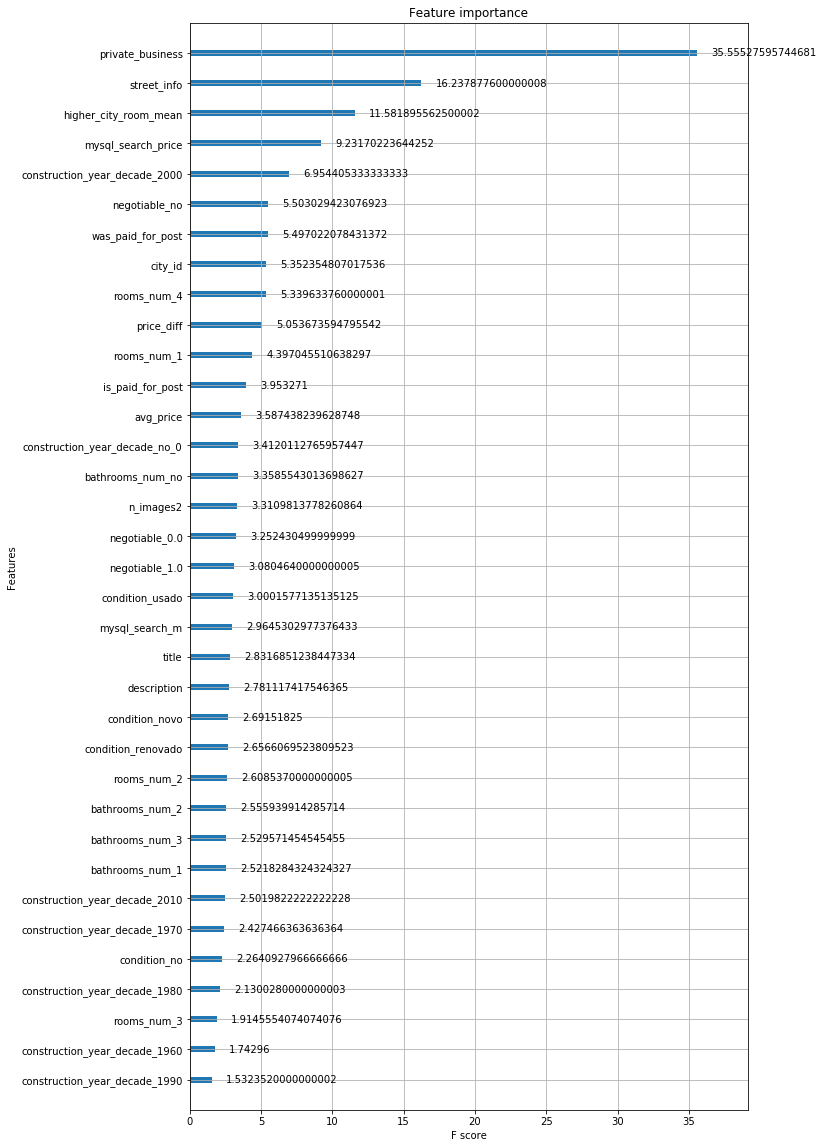

In [46]:
my_plot_importance(clf, figsize=(10, 20),  importance_type='gain' )

**Validation on train:**

In [47]:
y_train_predict = clf.predict(X_train)

In [48]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_train, y_train_predict)))
print('Precision: {0:.2f}'.format(precision_score(y_train, y_train_predict)))
print('Recall: {0:.2f}'.format(recall_score(y_train, y_train_predict)))
print('F1: {0:.2f}'.format(f1_score(y_train, y_train_predict)))

Accuracy: 0.87
Precision: 0.94
Recall: 0.87
F1: 0.90


In [49]:
pd.crosstab(
    pd.Series(y_train, name='Actual'),
    pd.Series(y_train_predict, name='Predicted'),
    margins=True
)

Predicted,0.0,1.0,All
Actual,,,
0.0,859,1498,2357
1.0,2510,4319,6829
All,3369,5817,9186


In [50]:
print(classification_report(y_train, y_train_predict))

             precision    recall  f1-score   support

          0       0.75      0.88      0.81      3800
          1       0.94      0.87      0.90      8450

avg / total       0.88      0.87      0.87     12250



**Validation on test:**

In [51]:
y_val_predict = clf.predict(X_test)

In [52]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_val_predict)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_val_predict)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_val_predict)))
print('F1: {0:.2f}'.format(f1_score(y_test, y_val_predict)))

Accuracy: 0.79
Precision: 0.87
Recall: 0.82
F1: 0.84


In [53]:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_val_predict, name='Predicted'),
    margins=True
)

Predicted,0.0,1.0,All
Actual,,,
0.0,80,169,249
1.0,275,481,756
All,355,650,1005


In [54]:
print(classification_report(y_test, y_val_predict))

             precision    recall  f1-score   support

          0       0.65      0.72      0.69      1289
          1       0.87      0.82      0.84      2795

avg / total       0.80      0.79      0.79      4084



**Validation on December data:**

In [55]:
for col in X.columns:
    if col not in X_cv.columns:
        print(col)
        X_cv[col] = 0

condition_em_construcao
condition_ruina
construction_year_decade_1700
construction_year_decade_1750
construction_year_decade_1820
construction_year_decade_1850
construction_year_decade_1890
construction_year_decade_1910
construction_year_decade_1920
construction_year_decade_2020


In [56]:
for col in X_cv.columns:
    if col not in X.columns:
        print(col)
        X_cv = X_cv.drop(col, axis=1)

In [57]:
selected_columns = X.columns 

In [58]:
y_cv_predict = clf.predict(X_cv[selected_columns])

In [59]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_cv, y_cv_predict)))
print('Precision: {0:.2f}'.format(precision_score(y_cv,  y_cv_predict)))
print('Recall: {0:.2f}'.format(recall_score(y_cv, y_cv_predict)))
print('F1: {0:.2f}'.format(f1_score(y_cv,  y_cv_predict)))

Accuracy: 0.81
Precision: 0.88
Recall: 0.82
F1: 0.85


In [60]:
pd.crosstab(
    pd.Series(y_cv, name='Actual'),
    pd.Series(y_cv_predict, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,592,153,745
1,251,1122,1373
All,843,1275,2118


In [61]:
print(classification_report(y_cv, y_cv_predict))

             precision    recall  f1-score   support

          0       0.70      0.79      0.75       745
          1       0.88      0.82      0.85      1373

avg / total       0.82      0.81      0.81      2118



In [62]:
from eli5 import show_weights
show_weights(clf)

Weight,Feature
0.2017,private_business
0.0921,street_info
0.0657,higher_city_room_mean
0.0524,mysql_search_price
0.0394,construction_year_decade_2000
0.0312,negotiable_no
0.0312,was_paid_for_post
0.0304,city_id
0.0303,rooms_num_4
0.0287,price_diff


**Average price for city_id/rooms_num combination**

In [63]:
avg_city = dataset_full.pipe(select_category, category_id = 102)\
.pipe(remove_outliers, col='mysql_search_price', lower_bound=100, upper_bound=2000)\
.pipe(filter_values, col='rooms_num', values_list=['0', '1', '2', '3', '4', '5', '6'])\
.pipe(remove_outliers, col='mysql_search_m', lower_bound=20, upper_bound=200)\
.pipe(count_avg_price_city_ap_type)

In [64]:
avg_city[avg_city['city_id'] == 11539464]

,city_id,rooms_num,avg_price
589,11539464,1,895.000000
590,11539464,2,1222.839506
591,11539464,3,1525.173913
592,11539464,4,1310.666667
593,11539464,5,1925.000000


In [65]:
avg_city.rooms_num = avg_city.rooms_num.astype('int')

In [66]:
avg_city.to_csv("avg_city_price_imo_rent_02.csv", index=None)

**Save model columns**

In [67]:
model_columns = list(X_train.columns)
joblib.dump(model_columns, 'model_columns_xgb_imo_rent_02.pkl')

['model_columns_xgb_imo_rent_02.pkl']

### Example how it works as a service ###

Input example:

In [68]:
data = {
        "city_id": 11539464,
        "title": 30,
        "description": 1000,
        "private_business": "private",
        "street_name" : "Vodickova",
        "rooms_num": 2,
        "mysql_search_m": 80,
        "mysql_search_price": 490,
        "construction_year": 1998,
        "n_images2": 10,
    }

In [69]:
def get_dataframe(json):
    df = pd.DataFrame.from_dict([dict(json)])
    return df

In [70]:
t1 = get_dataframe(data)

In [71]:
t1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 10 columns):
city_id               1 non-null int64
construction_year     1 non-null int64
description           1 non-null int64
mysql_search_m        1 non-null int64
mysql_search_price    1 non-null int64
n_images2             1 non-null int64
private_business      1 non-null object
rooms_num             1 non-null int64
street_name           1 non-null object
title                 1 non-null int64
dtypes: int64(8), object(2)
memory usage: 160.0+ bytes


In [72]:
t1 = t1.merge(avg_city, on= ['city_id', 'rooms_num'])

In [73]:
model_columns = ['city_id', 
                 'title', 
                 'description', 
                 'private_business',
                 'n_images2', 
                 'was_paid_for_post', 
                 'is_paid_for_post', 
                 'mysql_search_m',
                 'mysql_search_price', 
                 'rooms_num',
                 'bathrooms_num', 
                 'condition', 
                 'energy_certificate', 
                 'construction_year',
                 'negotiable',
                 'exchange',  
                 'avg_price',
                 'higher_city_room_mean', 
                 'construction_year']

In [74]:
for col in model_columns:
    if col not in t1.columns:
        print(col)
        t1[col] = None

was_paid_for_post
is_paid_for_post
bathrooms_num
condition
energy_certificate
negotiable
exchange
higher_city_room_mean


In [75]:
t1

,city_id,construction_year,description,mysql_search_m,mysql_search_price,n_images2,private_business,rooms_num,street_name,title,avg_price,was_paid_for_post,is_paid_for_post,bathrooms_num,condition,energy_certificate,negotiable,exchange,higher_city_room_mean
0,11539464,1998,1000,80,490,10,private,2,Vodickova,30,1222.839506,None,None,None,None,None,None,None,None


In [76]:
f2 = t1\
.pipe(add_higher_city_room_avg)\
.pipe(private_business_binarization)\
.pipe(column_info, col='construction_year', new_column_name='construction_year_info')\
.pipe(create_construction_decade)\
.pipe(column_info, col='street_name', new_column_name='street_info', drop=True)\
.pipe(column_info, col='energy_certificate', new_column_name='energy_certificate')\
.pipe(column_info, col='bathrooms_num', new_column_name='bathrooms_info')\
.pipe(column_info, col='condition', new_column_name='condition_info')\
.pipe(create_avg_price_diff, avg_price_col='avg_price', price_col='mysql_search_price', new_column_name= 'price_diff')

In [77]:
f2

,city_id,description,mysql_search_m,mysql_search_price,n_images2,private_business,rooms_num,title,avg_price,was_paid_for_post,...,energy_certificate,negotiable,exchange,higher_city_room_mean,construction_year_info,construction_year_decade,street_info,bathrooms_info,condition_info,price_diff
0,11539464,1000,80,490,10,1,2,30,1222.839506,None,...,0,None,None,0,1,1990,1,0,0,-0.599293


In [78]:
f2[num_columns] = f2[num_columns].fillna(0)

In [79]:
f2[cat_columns] = f2[cat_columns].fillna('no_info')

In [80]:
f2[cat_columns] = f2[cat_columns].astype('str')

In [81]:
f2 = pd.get_dummies(f2)

In [82]:
f2

,city_id,description,mysql_search_m,mysql_search_price,n_images2,private_business,title,avg_price,higher_city_room_mean,construction_year_info,...,bathrooms_info,condition_info,price_diff,rooms_num_2,bathrooms_num_no_info,condition_no_info,energy_certificate_0,negotiable_no_info,exchange_no_info,construction_year_decade_1990
0,11539464,1000,80,490,10,1,30,1222.839506,0,1,...,0,0,-0.599293,1,1,1,1,1,1,1


In [83]:
for col in X_train.columns:
    if col not in f2.columns:
        print(col)
        f2[col] = 0

was_paid_for_post
is_paid_for_post
rooms_num_1
rooms_num_3
rooms_num_4
bathrooms_num_1
bathrooms_num_2
bathrooms_num_3
bathrooms_num_4_ou_mais
bathrooms_num_no
condition_em_construcao
condition_no
condition_novo
condition_para_recuperar
condition_renovado
condition_ruina
condition_usado
energy_certificate_1
negotiable_0.0
negotiable_1.0
negotiable_no
exchange_0.0
exchange_no
construction_year_decade_1700
construction_year_decade_1750
construction_year_decade_1820
construction_year_decade_1850
construction_year_decade_1890
construction_year_decade_1900
construction_year_decade_1910
construction_year_decade_1920
construction_year_decade_1930
construction_year_decade_1940
construction_year_decade_1950
construction_year_decade_1960
construction_year_decade_1970
construction_year_decade_1980
construction_year_decade_2000
construction_year_decade_2010
construction_year_decade_2020
construction_year_decade_no_0


In [84]:
sel_cols = X_train.columns

In [85]:
f2 = f2[sel_cols]

In [86]:
clf.predict_proba(f2)

array([[0.09179032, 0.9082097 ]], dtype=float32)

In [87]:
test_f2 = f2.iloc[0]

In [88]:
from eli5 import show_prediction
show_prediction(clf, test_f2, show_feature_values=True, top=10)